<a href="https://colab.research.google.com/github/feras-nahhal/insurance-claims-analysis/blob/main/insurance_risk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


# Import packages
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import set_config
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
set_config(transform_output='pandas')


# file path from google drive
path= '/content/drive/MyDrive/AXSOSACADEMY/03-DataEnrichment/Week09/Data/Car_Insurance_Claim.csv'

df = pd.read_csv(path)
df=df.set_index('ID')
df.info()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICL

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [82]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

1. What is the target?

2. What does one row represent? insurance customer "person"
3. How many features does the data have? 18 including the target "17 input features"
4. How many rows are in the dataset?  10,000
5. What opportunities exist for dimensionality reduction or feature selection with this dataset?
- Filter Methods (Correlation, Variance)
- Embedded Methods (Logistic Regression, Tree Importance)
- Wrapper Methods (Sequential Feature Selection)

6. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?
- Many categorical columns to encode, class imbalance, sparse features after one-hot encoding

In [83]:
#Check for missing values. You should produce an output showing the number of missing values for each feature.
df.isna().sum()

,0
AGE,0
GENDER,0
RACE,0
DRIVING_EXPERIENCE,0
EDUCATION,0
INCOME,0
CREDIT_SCORE,982
VEHICLE_OWNERSHIP,0
VEHICLE_YEAR,0
MARRIED,0


In [84]:
#Check for and address any inconsistent values in object columns. (do not drop the entire feature)
# Saving list of column names for object_columns
object_columns = df.select_dtypes(include=['object']).columns
object_columns

# Obtain the value counts for all object columns
for column in object_columns:
  print(f"Value Counts for {column}")
  print(df[column].value_counts())
  print('========================')
  print('\n')


Value Counts for AGE
AGE
26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: count, dtype: int64


Value Counts for GENDER
GENDER
female    5010
male      4990
Name: count, dtype: int64


Value Counts for RACE
RACE
majority    9012
minority     988
Name: count, dtype: int64


Value Counts for DRIVING_EXPERIENCE
DRIVING_EXPERIENCE
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: count, dtype: int64


Value Counts for EDUCATION
EDUCATION
high school    4157
university     3928
none           1915
Name: count, dtype: int64


Value Counts for INCOME
INCOME
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: count, dtype: int64


Value Counts for VEHICLE_YEAR
VEHICLE_YEAR
before 2015    6967
after 2015     3033
Name: count, dtype: int64


Value Counts for VEHICLE_TYPE
VEHICLE_TYPE
sedan         9523
sports car     477
Name: count, dtype: int64




In [85]:
# Check for and address any impossible values in numeric columns.

# Saving list of column names for numeric_columns
numeric_columns = df.select_dtypes('number').columns
numeric_columns

# Obtain the describition for all numeric columns
for column in numeric_columns:
  print(f"describition for {column}")
  print(df[column].describe())
  print('========================')
  print('\n')

describition for CREDIT_SCORE
count    9018.000000
mean        0.515813
std         0.137688
min         0.053358
25%         0.417191
50%         0.525033
75%         0.618312
max         0.960819
Name: CREDIT_SCORE, dtype: float64


describition for VEHICLE_OWNERSHIP
count    10000.000000
mean         0.697000
std          0.459578
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: VEHICLE_OWNERSHIP, dtype: float64


describition for MARRIED
count    10000.000000
mean         0.498200
std          0.500022
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: MARRIED, dtype: float64


describition for CHILDREN
count    10000.000000
mean         0.688800
std          0.463008
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: CHILDREN, dtype: float64


describition for POSTAL_CODE
count    10000.

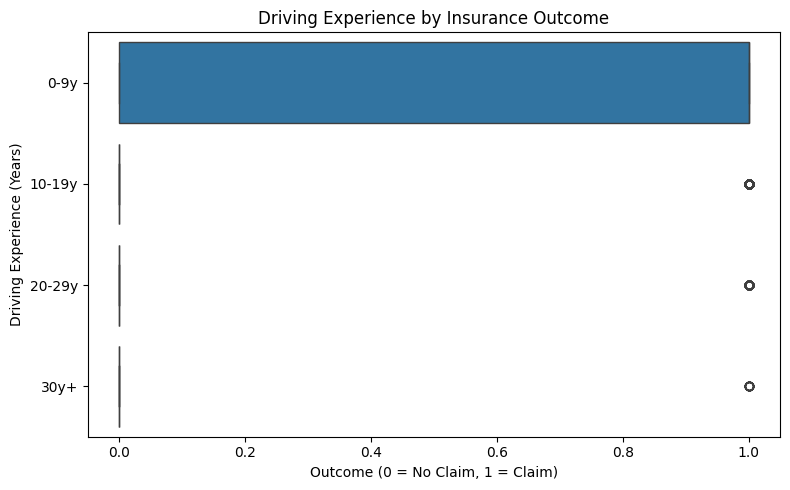

In [86]:
# Boxplot of Driving Experience by Outcome
plt.figure(figsize=(8, 5))
sns.boxplot(x='OUTCOME', y='DRIVING_EXPERIENCE', data=df)
plt.title('Driving Experience by Insurance Outcome')
plt.xlabel('Outcome (0 = No Claim, 1 = Claim)')
plt.ylabel('Driving Experience (Years)')
plt.tight_layout()
plt.show()

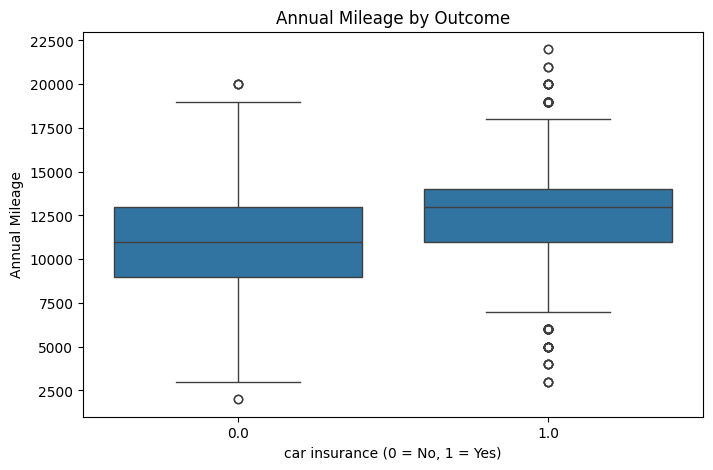

In [87]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='OUTCOME', y='ANNUAL_MILEAGE', data=df)
plt.title('Annual Mileage by Outcome')
plt.xlabel('car insurance (0 = No, 1 = Yes)')
plt.ylabel('Annual Mileage')
plt.show()


In [88]:
# Define target
target_col = 'OUTCOME'

# Make list of columns to drop. In this case just the id column for now
drop_cols = ['POSTAL_CODE']

# Define X and y
y = df[target_col].copy()
X = df.drop(columns=[target_col,*drop_cols]).copy()

# Train test split
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)

In [89]:
#PREPROCESSING PIPELINE FOR NUMERIC DATA
# Save list of column names
num_cols = X.select_dtypes('number').columns
print("Numeric Columns:", num_cols)

# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)

# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

Numeric Columns: Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'],
      dtype='object')


In [90]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = ['GENDER',"RACE","VEHICLE_TYPE"]
print("OneHotEncoder Columns:", ohe_cols)

# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(ohe_encoder)

# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

OneHotEncoder Columns: ['GENDER', 'RACE', 'VEHICLE_TYPE']


In [91]:
# Prepare ordinal pipeline
# Save list of column names
ord_cols = ['AGE','DRIVING_EXPERIENCE','EDUCATION','VEHICLE_YEAR']
print("ordinal Columns:", ord_cols)

# Specifying the order of categories in quality/condition columns
AGE_order = ['26-39','40-64','16-25','65+']
DRIVING_EXPERIENCE_order = ["0-9y","10-19y","20-29y","30y+"]
EDUCATION_order = ['high school','university','none']
VEHICLE_YEAR_order = ["before 2015","after 2015"]

# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [AGE_order, DRIVING_EXPERIENCE_order,EDUCATION_order,VEHICLE_YEAR_order ]

# Ordinal Encoder
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

# make a pipeline
ord_pipe = make_pipeline( ord_encoder)
ord_tuple = ('ordinal', ord_pipe, ord_cols)

ordinal Columns: ['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'VEHICLE_YEAR']


In [92]:
# Define a column transformer
preprocessor  = ColumnTransformer([num_tuple, ohe_tuple,ord_tuple],
                                  verbose_feature_names_out=False)

In [93]:
# Instantiate default random forest model
rf = RandomForestClassifier(random_state=42)
# Model Pipeline
rf_pipe_Classifier = make_pipeline(preprocessor, rf)

In [94]:
# Fit the model pipeline on the training data only
rf_pipe_Classifier.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeli...
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['26-39',
                                                                                               '40-64',
                                                                                               '16-25',
                                                                                               '65+'],
                                                                                              ['0-9y',
                                                                                               '10-19y',
                                                                                               '20-29y',
                                                                                               '30y+'],
                                                                                              ['high '
                                                                                               'school',
                                                                                               'university',
                                                                                               'none'],
                                                                                              ['before '
                                                                                               '2015',
                                                                                               'after '
                                                                                               '2015']]))]),
                                                  ['AGE', 'DRIVING_EXPERIENCE',
                                                   'EDUCATION',
                                                   'VEHICLE_YEAR'])],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5119
         1.0       1.00      1.00      1.00      2381

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



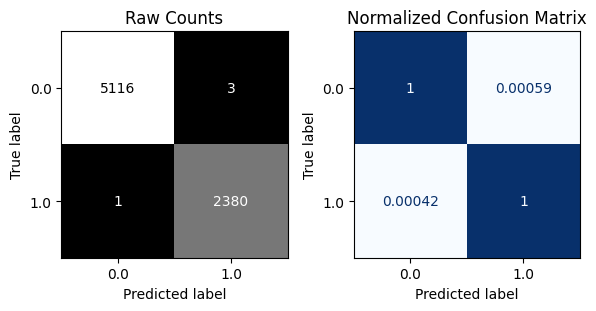


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1748
         1.0       0.75      0.66      0.70       752

    accuracy                           0.83      2500
   macro avg       0.81      0.78      0.79      2500
weighted avg       0.83      0.83      0.83      2500



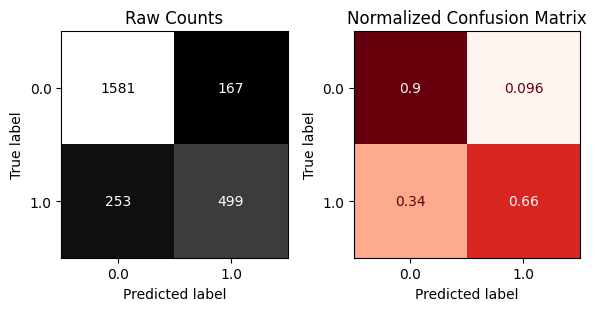

In [95]:
evaluate_classification(rf_pipe_Classifier, X_train, y_train, X_test, y_test)

In [96]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

In [97]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

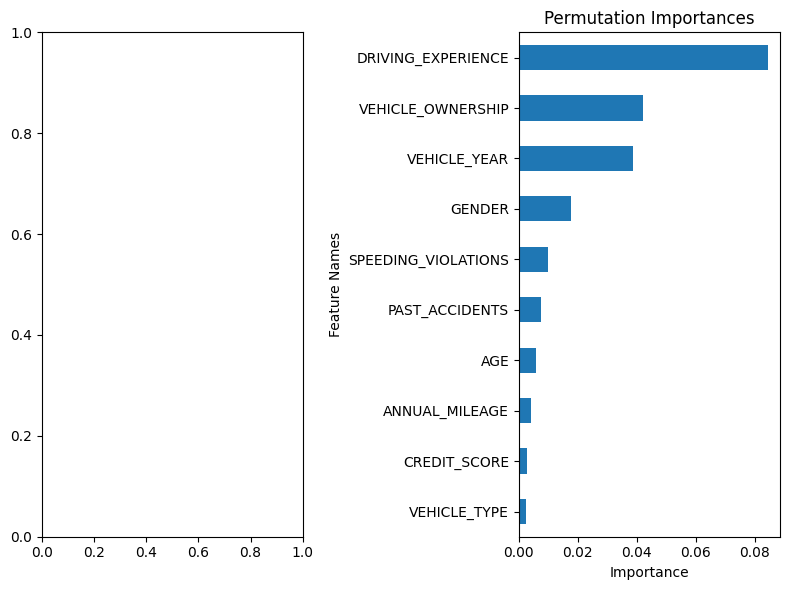

In [98]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Get permutation importance using the trained model and test data
r = permutation_importance(
    rf_pipe_Classifier, X_test, y_test,
    n_repeats=30, random_state=42, n_jobs=-1
)

# Create a Series from mean importances
permutation_importances = pd.Series(
    r['importances_mean'],
    index=X_test.columns,
    name='Permutation Importance'
).sort_values(ascending=False)



# Create side-by-side plots
fig, axes = plt.subplots(ncols=2, figsize=(20, 8))
n = 10  # Number of top features to show

plot_importance_color_ax(permutation_importances, top_n=n, ax=axes[1])

# Set plot titles

axes[1].set(title='Permutation Importances')

# Finalize layout
fig.tight_layout()
plt.show()


- Add your observations in a Markdown: Do these features make sense based on the business case?


from the permutation importance the top Key features is driving experience, vehicle year, and past accidents, and they make a lot of sense for real world application as newer car with good driving experience make the best predicting.

- Create Explanatory Visualizations for the most important features.
1. Driving Experience vs Insurance Claims
2. Vehicle Ownership vs Insurance Claims

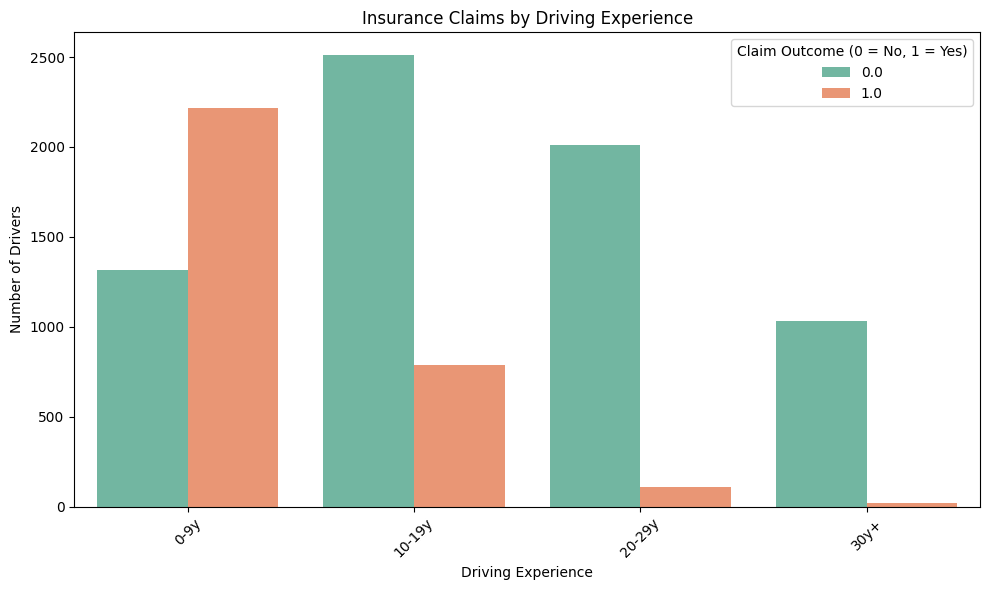

In [99]:
#Driving Experience vs Insurance Claims
plt.figure(figsize=(10,6))
sns.countplot(x='DRIVING_EXPERIENCE', hue='OUTCOME', data=df, palette='Set2')
plt.title('Insurance Claims by Driving Experience')
plt.xlabel('Driving Experience')
plt.ylabel('Number of Drivers')
plt.legend(title='Claim Outcome (0 = No, 1 = Yes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


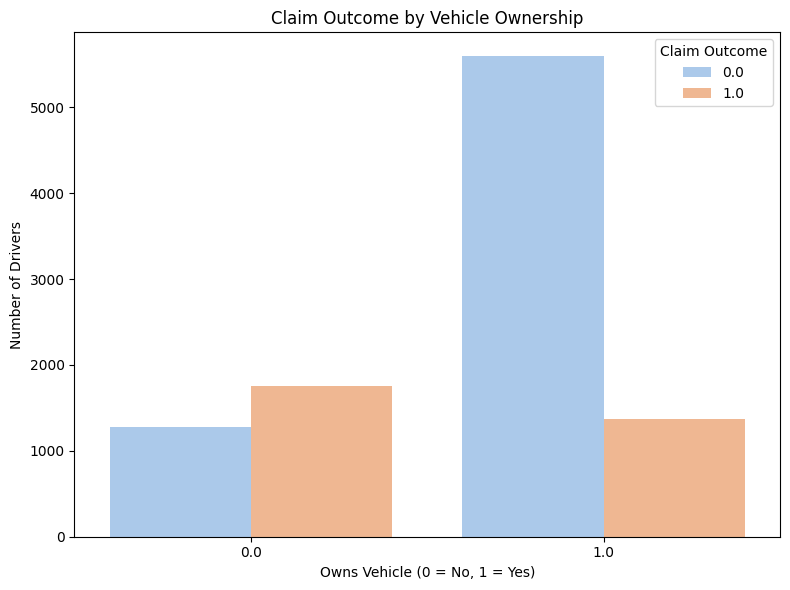

In [100]:
#Vehicle Ownership vs Insurance Claims
plt.figure(figsize=(8,6))
sns.countplot(x='VEHICLE_OWNERSHIP', hue='OUTCOME', data=df, palette='pastel')
plt.title('Claim Outcome by Vehicle Ownership')
plt.xlabel('Owns Vehicle (0 = No, 1 = Yes)')
plt.ylabel('Number of Drivers')
plt.legend(title='Claim Outcome')
plt.tight_layout()
plt.show()

- Apply PCA to get 3 principal components for the data. Concatenate/combine these PC’s with the original features (X_train, X_test data).
- Remember to only fit the PCA on the training data and use pca.transform(X_test) to get the PCs for the testing data.
- Apply clustering, select the appropriate number of clusters, and use the clustering object to get predicted cluster labels for the training and test data. Concatenate/combine these clusters with the original features.
- Remember to only fit KMeans on the training data and use kmeans.predict(X_test) to create cluster labels for the test data.
- Create additional features by applying the feature engineering techniques demonstrated in the LP.

In [101]:
# Preprocess separately
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
# Define PCA to address 3 principal components for the data.
from sklearn.decomposition import PCA
# Instantiate PCA with 3 components
pca3 = PCA(n_components=3)
# fit and transform on training data
X_train_pca3 = pca3.fit_transform(X_train_transformed)
# transform test data
X_test_pca3 = pca3.transform(X_test_transformed)
# obtain the number of PCs used
pca3.n_components_

3

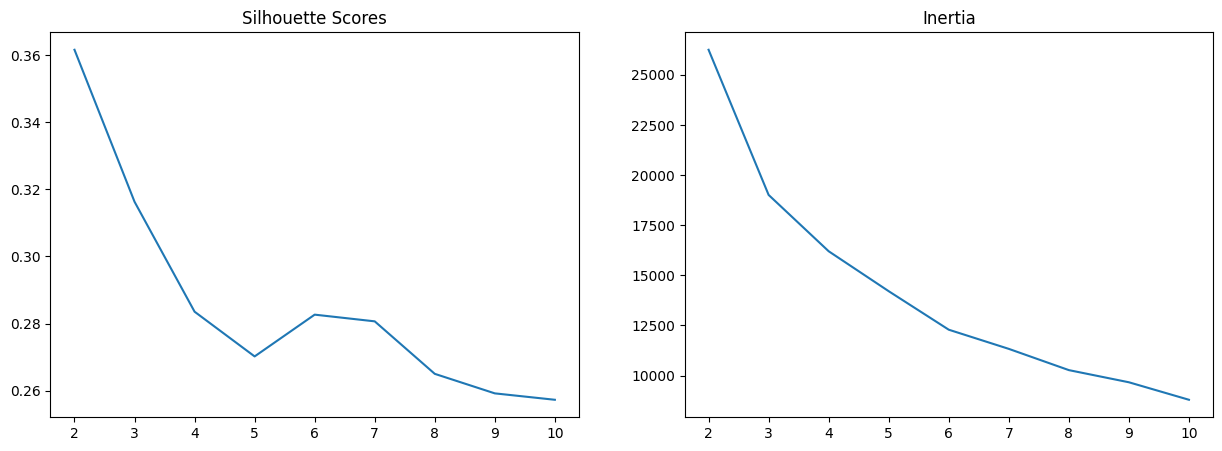

In [102]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=42)
  kmeans.fit(X_train_pca3)
  sils.append(silhouette_score(X_train_pca3, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

In [103]:
# Fit kmeans model with 2 clusters and display the silhouette score
kmeans = KMeans(n_clusters = 2, n_init = 'auto', random_state = 42)
kmeans.fit(X_train_pca3)
silhouette_score(X_train_pca3, kmeans.labels_)


np.float64(0.3615417341043502)

- we will use kmeans model with 2 clusters

In [104]:
kmeans.predict(X_test_pca3)

array([0, 1, 1, ..., 0, 0, 1], dtype=int32)

In [105]:
df['gender_age']=df['GENDER']+df['AGE']
df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,gender_age
ID,,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0,female65+
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0,male16-25
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0,female16-25
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0,male16-25
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0,male26-39


- Fit and evaluate a model using your new features and compare it to your model from Part 1.

In [106]:
# Instantiate default random forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca3, y_train)

RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5119
         1.0       1.00      1.00      1.00      2381

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500



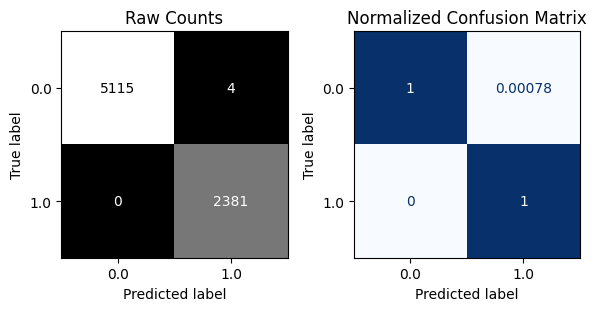


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84      1748
         1.0       0.65      0.56      0.60       752

    accuracy                           0.78      2500
   macro avg       0.73      0.71      0.72      2500
weighted avg       0.77      0.78      0.77      2500



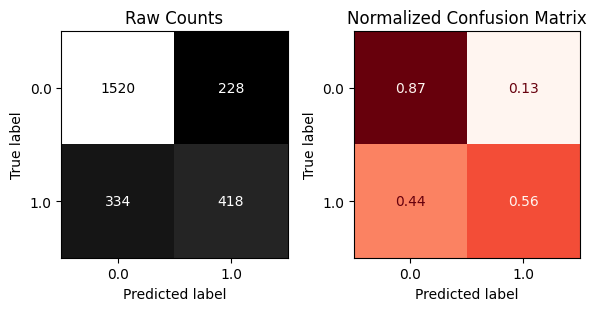

In [107]:
evaluate_classification(rf, X_train_pca3, y_train, X_test_pca3, y_test)

Note:
- Before we applied PCA, our car insurance model was doing great — perfect scores in training and about 83% accuracy on the test data. After PCA, training still looked perfect, but test accuracy slipped to 78%. The biggest drop was in predicting customers who would actually make a claim (class 1.0) — we started missing more real claims and also flagging more false ones.

- In other words, reducing the data dimensions helped simplify the model.


In [108]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
# Instantiate the model
dt = DecisionTreeClassifier(random_state = 42)
# Instantiate the SequentialFeatureSelector
sfs = SequentialFeatureSelector(dt, n_features_to_select=10,
                                direction = 'forward', cv=2,
                                 n_jobs=-1)
sfs.fit(X_train_transformed,y_train)

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeClassifier(random_state=42),
                          n_features_to_select=10, n_jobs=-1)

In [109]:
# Preview array
sfs.support_[0:5]

array([False,  True,  True,  True, False])

In [110]:
# .support_ returns an array of T/F whether it is above threshold
features_to_keep = sfs.support_
# Only include the features selected
X_train_10 = X_train_transformed.loc[:,features_to_keep]
X_test_10 = X_test_transformed.loc[:,features_to_keep]
X_train_10.shape

(7500, 10)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      5119
         1.0       0.77      0.73      0.75      2381

    accuracy                           0.85      7500
   macro avg       0.82      0.82      0.82      7500
weighted avg       0.84      0.85      0.84      7500



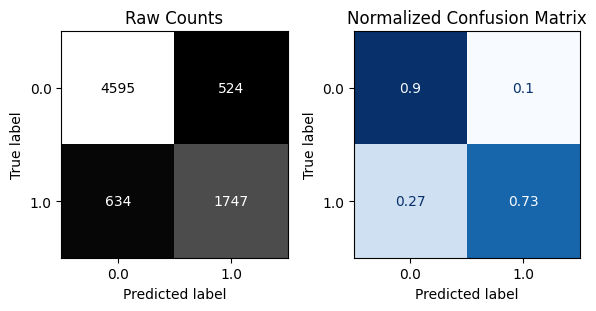


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89      1748
         1.0       0.74      0.74      0.74       752

    accuracy                           0.85      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.85      0.85      0.85      2500



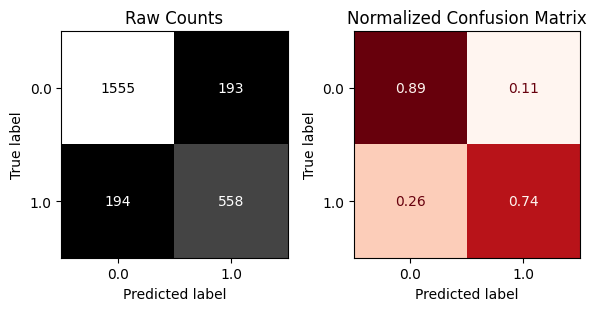

In [111]:
# Instantiate default random forest
rf_clf = RandomForestClassifier(random_state=42)
# Fit on 39 selected featuers
rf_clf.fit(X_train_10, y_train)
# Evaluate with custom function
evaluate_classification(rf_clf, X_train_10, y_train, X_test_10, y_test)

- Extract and visualize the top 10 features using permutation importance (from Intro to ML Week 4).
- In a Markdown cell, comment on how these features compare to the model from Part 1. Are there any new features in the top 10?


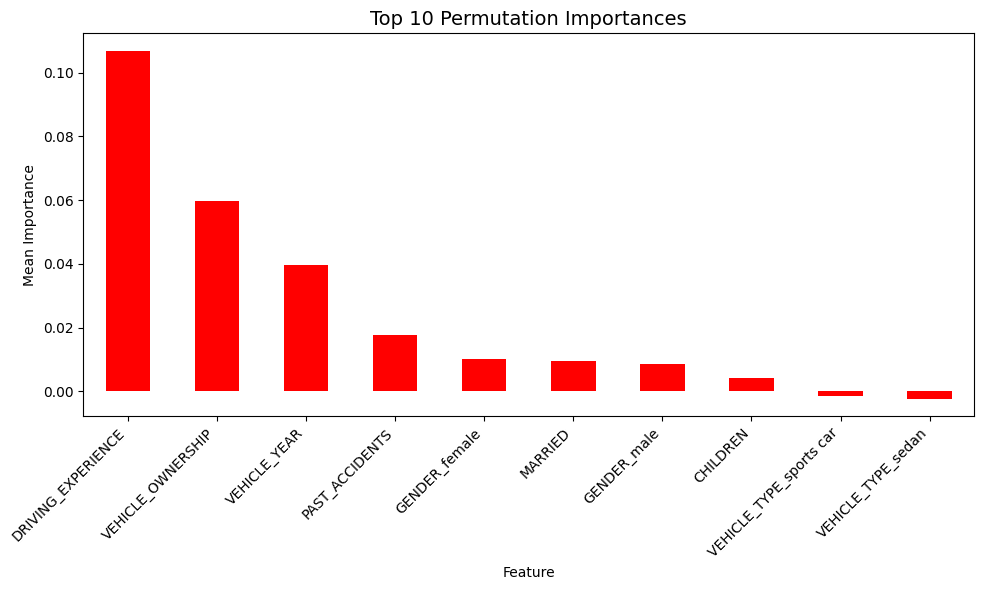

In [112]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

#Calculate permutation importance for rf_clf
r = permutation_importance(
    rf_clf,
    X_test_10,
    y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

# Create a sorted Series of importances
permutation_importances = pd.Series(
    r['importances_mean'],
    index=X_test_10.columns,
    name='Permutation Importance'
).sort_values(ascending=False)

#Plot the top 10 features
fig, ax = plt.subplots(figsize=(10, 6))
n = 10
permutation_importances.head(n).plot.bar(ax=ax, color='red')
ax.set_title('Top 10 Permutation Importances', fontsize=14)
ax.set_ylabel('Mean Importance')
ax.set_xlabel('Feature')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


- Build a small neural network (with only 1 hidden layer)
- Ensure the final layer is appropriate for your task (number of units and activation function).
- Fit it for 50 epochs
- Use the Early Stopping callback
- Start with patience =5 monitoring val_accuracy.
- Use a validation_split of .2
- Save the history and visualize it.
- Evaluate the model using sklearn evaluation metrics:
- Confusion Matrix
- Classification Report
- You are welcome to use the custom evaluation functions

In [113]:
input_shape = X_train_transformed.shape[1]
input_shape

18

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

# Sci-kit learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [115]:
# Build binary classification model within function
def build_model():
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(10, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(10,
                activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [116]:
# Call our build function to build model
clf_model = build_model()

# Get model summary
clf_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 10)             │           190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311 (1.21 KB)

 Trainable params: 311 (1.21 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',  # monitor validation accuracy instead of loss
    patience=5,               # wait 5 epochs without improvement before stopping
    restore_best_weights=True # optional but recommended
)

In [118]:
history = clf_model.fit(X_train_transformed, y_train,
                        validation_split=.2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])

In [119]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

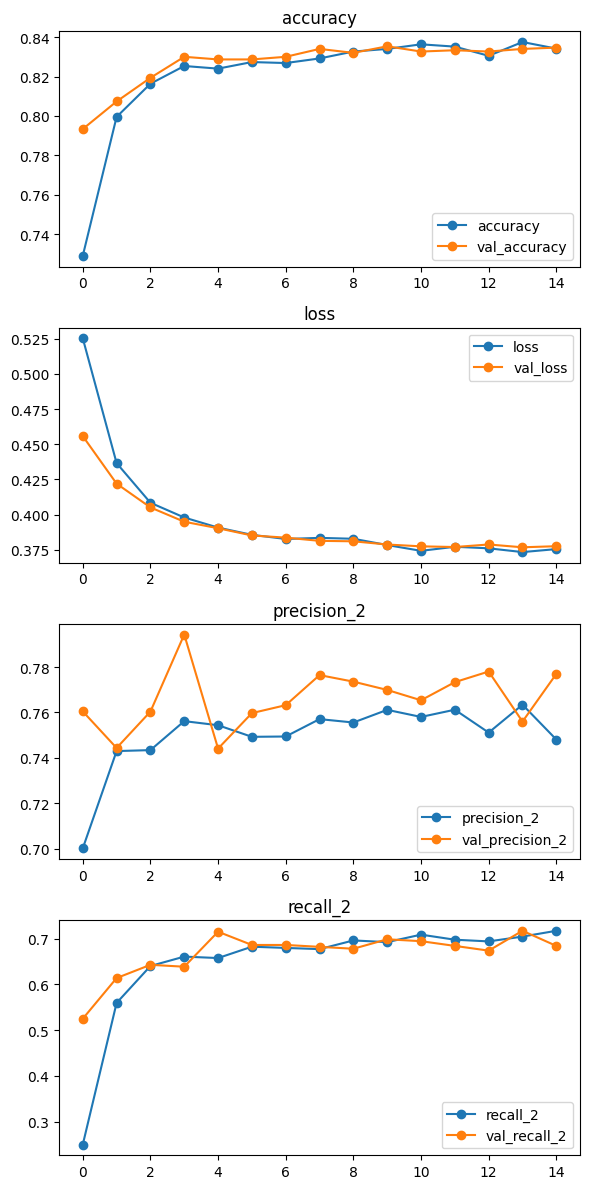

In [120]:
# Call the custom function
plot_history(history);

In [121]:
# make predictions
y_pred_test = clf_model.predict(X_test_transformed)
y_pred_test[:5]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


array([[0.3097872 ],
       [0.01537984],
       [0.00797969],
       [0.17578745],
       [0.016503  ]], dtype=float32)

In [122]:
# round the predictions
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      1748
         1.0       0.76      0.73      0.74       752

    accuracy                           0.85      2500
   macro avg       0.82      0.82      0.82      2500
weighted avg       0.85      0.85      0.85      2500



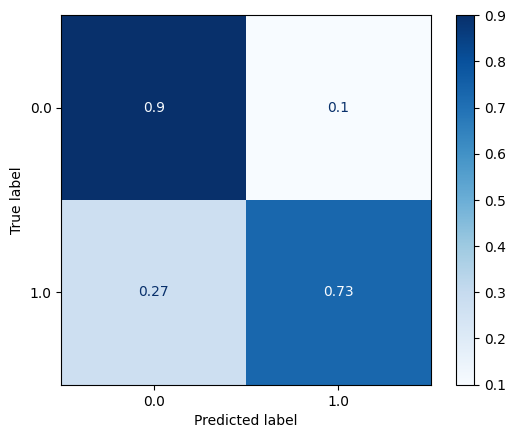

In [123]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues',
                                       normalize='true');

In [124]:
# Evaluate neural network with built in evaluation
result = clf_model.evaluate(X_test_transformed, y_test, return_dict=True)
result

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8335 - loss: 0.3849 - precision_2: 0.7454 - recall_2: 0.7045


{'accuracy': 0.8492000102996826,
 'loss': 0.36534029245376587,
 'precision_2': 0.7593361139297485,
 'recall_2': 0.730053186416626}

- Tune at least 3 parameters with the Keras tuner:
- Include a dropout layer and adjust the dropout rate.
- Number of Units
- Optimizer
- Learning rates
- Evaluate your best model on unseen test data

In [125]:
!pip install keras-tuner --quiet


In [126]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt

In [127]:
# Build and Compile Model within a function to try different optimizers, units, and dropout values
def build_model1(hp):
    # Instantiate Model
    model = Sequential()
    # First hidden layer
    model.add(Dense(19, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    # Try different values for units
    model.add(Dense(units=hp.Int('units', min_value=10, max_value=50, step=5), activation='relu'))
    # Try different values for dropout rate
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    # Try different optimizers
    model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='bce',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    return model

In [128]:
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [129]:
# Define tuner object
tuner = kt.Hyperband(build_model1,
                     objective='val_accuracy',
                     max_epochs=100,
                     directory=folder,
                     overwrite = True,
                     seed = 42,
                     project_name='Rookie_tuning')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [130]:
# Run the tuner
epochs = 50
tuner.search(X_train_transformed, y_train,
                        validation_split=.2,  epochs=epochs,
              callbacks = [early_stop])

Trial 172 Complete [00h 00m 09s]
val_accuracy: 0.8299999833106995

Best val_accuracy So Far: 0.8513333201408386
Total elapsed time: 00h 21m 50s


In [131]:
# Obtain best hyperparameter values
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 50,
 'dropout_value': 0.2,
 'optimizer': 'adam',
 'tuner/epochs': 34,
 'tuner/initial_epoch': 12,
 'tuner/bracket': 4,
 'tuner/round': 3,
 'tuner/trial_id': '0131'}

In [132]:
# Obtain best model
best_model = tuner.get_best_models()[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 19)             │           361 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,412 (5.52 KB)

 Trainable params: 1,412 (5.52 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
# Evaluate neural network with built in evaluation
result = best_model.evaluate(X_test_transformed, y_test, return_dict=True)
result

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8414 - loss: 0.3828 - precision: 0.7463 - recall: 0.7402


{'accuracy': 0.8539999723434448,
 'loss': 0.36466163396835327,
 'precision': 0.7618403434753418,
 'recall': 0.748670220375061}

In [134]:
# Inspect results in more detail
tuner.results_summary(5)

Results summary
Results in KerasTuner/Rookie_tuning
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 0142 summary
Hyperparameters:
units: 50
dropout_value: 0.2
optimizer: adam
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0131
Score: 0.8513333201408386

Trial 0146 summary
Hyperparameters:
units: 50
dropout_value: 0.2
optimizer: adam
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 0.8493333458900452

Trial 0131 summary
Hyperparameters:
units: 50
dropout_value: 0.2
optimizer: adam
tuner/epochs: 12
tuner/initial_epoch: 4
tuner/bracket: 4
tuner/round: 2
tuner/trial_id: 0098
Score: 0.8473333120346069

Trial 0145 summary
Hyperparameters:
units: 50
dropout_value: 0.1
optimizer: nadam
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0137
Score: 0.8473333120346069

Trial 0141 summary
Hyperparameters:
units: 30
dropout_value: 0.1
opt